## Exercises

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

from functools import wraps
from numba import njit

## Q1: The stock market

(This is about numba)

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value. This is a crucial tool in statistics, widely used in science and beyond (economics for instance).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would be a Markov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

where the numbers on the arrows indicate the probability that the next day will be in a given state.

Your task is to simulate the stock market according to this rule. Start from a random state and simulate many many  iterations. If your code is right, the fraction of days in each state should converge. 

Implement a pure-python version and a numba version, and compare speeds. 


In [2]:
transition_matrix = np.array(
    [
        [0.9, 0.075, 0.025], # Bull
        [0.15, 0.8, 0.05],   # Bear
        [0.25, 0.25, 0.5],   # Stagnant
    ]
)

BULL, BEAR, STAGNANT = 0, 1, 2


# Python
def simulate_markov_chain_python(num_steps):
    state_counts = [0, 0, 0]
    current_state = np.random.choice([BULL, BEAR, STAGNANT])
    for _ in range(num_steps):
        state_counts[current_state] += 1
        current_state = np.random.choice(
            [BULL, BEAR, STAGNANT], p=transition_matrix[current_state]
        )
    return np.array(state_counts) / num_steps


# Numba
@njit
def custom_choice(probabilities):
    r = np.random.uniform()
    cumulative_probability = 0.0
    for i, p in enumerate(probabilities):
        cumulative_probability += p
        if r < cumulative_probability:
            return i
    return len(probabilities) - 1


@njit
def simulate_markov_chain_numba(num_steps):
    state_counts = np.zeros(3, dtype=np.int64)
    current_state = np.random.randint(0, 3)
    for _ in range(num_steps):
        state_counts[current_state] += 1
        current_state = custom_choice(transition_matrix[current_state])
    return state_counts / num_steps


# Test and compare performance
num_steps = 1_000_000

# Measure execution time for Python
start_time = time.time()
fractions_python = simulate_markov_chain_python(num_steps)
end_time = time.time()
print("Pure-Python implementation:")
print("State fractions:", fractions_python)
print("Time taken:", end_time - start_time, "sec")

# Measure execution time for Numba
start_time = time.time()
fractions_numba = simulate_markov_chain_numba(num_steps)
end_time = time.time()
print("Numba-optimized implementation:")
print("State fractions:", fractions_numba)
print("Time taken:", end_time - start_time, "sec")

Pure-Python implementation:
State fractions: [0.624176 0.312968 0.062856]
Time taken: 19.83229899406433 sec
Numba-optimized implementation:
State fractions: [0.622501 0.314738 0.062761]
Time taken: 1.363097906112671 sec


## Q2: Consistent plotting

(This is about python's dectorators)

Write a decorator for the plots of all your papers. 

- Remember a decorator takes a function. 
- This function in turn should return a matplotlib figure object.
- Before the function is called, the decorator should initialize a matplotlib figure with the options that you like the most (fontsize, ticks, etc etc)
- After the figure it's done, the decorator should save it to pdf.

This is a great hack for your papers! You do this once and for all, and all plots in your paper will be beautifull, all with the same style/fontsize/etc. All you'll need to do is adding `@myplot` to the relevant plotting functions. 
    
The decorator that I use for my papers is available in my python module [skywalker](https://github.com/dgerosa/skywalker).  

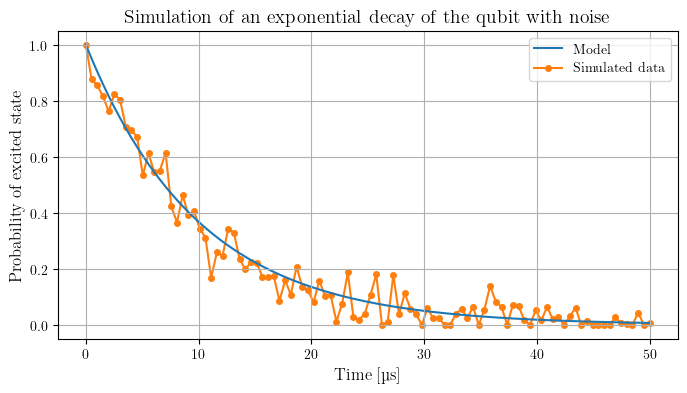

In [3]:
def myplot(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        import seaborn as sns
        
        plt.rcParams.update({
            "ytick.color": "black",
            "xtick.color": "black",
            "axes.labelcolor": "black",
            "axes.edgecolor": "black",
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Computer Modern Serif"],
            'font.size': 12,
            'figure.figsize': (8, 4),
            'axes.titlesize': 14,
            'axes.labelsize': 12,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 10,
            'figure.dpi': 100,
            'savefig.dpi': 300,
            'savefig.format': 'pdf'
        })
        
        fig = plt.figure()
        
        func()
        
        plt.legend()
        plt.grid(True)
        fig.savefig(f"misc/{func.__name__}.pdf")
        plt.show()
        
        return
    
    return wrapper

@myplot
def test():
    t1 = 10e-6
    t_max = 50e-6
    num_points = 100
    

    time = np.linspace(0, t_max, num_points)
    
    prob_excited = np.exp(-time / t1)
    noise = np.random.normal(0, 0.05, num_points)
    prob_excited_noisy = prob_excited + noise
    prob_excited_noisy = np.clip(prob_excited_noisy, 0, 1)
    
    plt.plot(time * 1e6, prob_excited, label='Model', zorder=1)
    plt.plot(time * 1e6, prob_excited_noisy, label='Simulated data', marker='o', markersize="4", zorder=0)
    plt.title('Simulation of an exponential decay of the qubit with noise')
    plt.xlabel('Time [µs]')
    plt.ylabel('Probability of excited state')

test()